In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4
import pandas as pd
import datetime
import pytz 
from tzwhere import tzwhere
import math
from suntime import Sun
from IPython.display import Image

In [3]:
import imageio.v2 

### This code is suppose to read in the data, extract only the nighttimes for the cities (based on lon lat)

In [4]:
def get_data(len_data, NU_WU):
    ds_data = {}
    for i in range(1, len_data + 1):
        filename = f'./data_all/fc_DOM01_0{i:03d}_{NU_WU}_urban_grid.nc'
        try:
            ds_data[i] = xr.open_dataset(filename)
            print(f'Successfully opened {filename}')
        except FileNotFoundError:
            print(f'File not found: {filename}')
        except Exception as e:
            print(f'An error occurred while opening {filename}: {e}')

    return ds_data


def get_variable_1d(len_data, data, variable, height_level, hour): #data is the output of 'get_data', variable is e.g. 'T' (as str), height_level (mostly 1 for urban), hour is time in this case 0 because one file only has one timestep
    ds_data = {}
    for i in range(1, len_data+1):
        ds_data[i] = data[i][f'{variable}'].isel(time = hour, height_2 = height_level)
    
    return ds_data

def prepare_sun(number_cities, data, file): #number of cities depends on input and % of landuse tiles, file defines in which hour you want to define since all hours are stored in one xarray dataset
    sun = {}
    for i in range(number_cities):
        sun[i] = Sun(data[file].clat[i].to_numpy()*180/math.pi, data[file].clon[i].to_numpy()*180/math.pi)
    
    return sun

def get_sunrise_sunset(number_cities, input_time, input_sun): #input_sun is the output of 'def prepare_sun'
    sunrise = {}
    sunset = {}
    for i in range(number_cities):
        sunrise[i] = input_sun[i].get_local_sunrise_time(input_time).time()
        sunrise[i] = pytz.utc.localize(sunrise[i])
    for i in range(number_cities):
        sunset[i] = input_sun[i].get_local_sunset_time(input_time).time()
        sunset[i] = pytz.utc.localize(sunset[i])
    
    return sunrise, sunset

def binary_daynight_corrected(number_cities, sunrise, sunset, hour):  
    time = datetime.time(hour)
    time = pytz.utc.localize(time)
    daynight = []
    
    for i in range(number_cities):
        if (sunset[i] < sunrise[i] and sunset[i]<= time <= sunrise[i]) or (sunset[i] > sunrise[i] and (time > sunset[i] or time < sunrise[i])):
            daynight.append('Night')
        else:
            daynight.append('Day')

    return daynight

def get_night(binary_data, data):
    data_night = {}

    for i, dataset in data.items():
        dataset = dataset.expand_dims(dim={"day_night": binary_data})
        
        data_night[i] = dataset.where(dataset['day_night'] != 'Day')
    
    return data_night, dataset

#### Data_WU means "Data With Urban" and Data_NU "Data No Urban". Data_WU is a dict with 120 Xarray Datasets stored in them. Each Dataset represents 1 hour of the output. Each Dataset has the dimension "cell" which are the urban grid cells. 

In [5]:
#Reading in the data 

data_WU = get_data(120, 'WU')
data_NU = get_data(120, 'NU')

Successfully opened ./data_all/fc_DOM01_0001_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0002_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0003_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0004_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0005_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0006_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0007_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0008_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0009_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0010_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0011_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0012_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0013_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0014_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0015_WU_urban_grid.nc
Successfully opened ./data_all/fc_DOM01_0016_WU_urban_grid.nc
Successf

In [6]:
#prepare sun #convert radiant to lat lon 

sun_WU = {}
sun_NU = {}

for i in range(1, 121):
    sun_WU[i] = prepare_sun(247, data_WU, i)
    
for i in range(1, 121):
    sun_NU[i] = prepare_sun(247, data_NU, i)


In [7]:
#get sunrise sunset based on the lat lon values from the dataset

sunrise_WU = {}
sunrise_NU = {}

sunset_WU = {}
sunset_NU = {}

time_zone = datetime.date(2021,7,4)

for i in range(1, 121):
    sunrise_WU[i], sunset_WU[i] = get_sunrise_sunset(247, time_zone , sun_WU[i])

for i in range(1,121):
    sunrise_NU[i], sunset_NU[i] = get_sunrise_sunset(247, time_zone , sun_NU[i])

In [8]:
#create time_array for the hours because it is easier to calculate with. Added zero in the beginning because ICON output and Python have different indexing

time_array = []

for i in range(121):
    time_array.append(i % 24)

numbers_to_add = [0, 21, 22, 23]  # Numbers to add

# Use the insert method to add numbers to the beginning of the array
for num in reversed(numbers_to_add):
    time_array.insert(0, num)


In [9]:
#corrected version. Before the intervall between sunset and sunrise was wrongly defined for hours. Can delete the first version but just in case 

daynight_WU = {}
daynight_NU = {}

#time_array = [0,21, 22, 23, 24, 1, 2]

for i in range(1, 121):
    j = time_array[i]
    daynight_WU[i] = binary_daynight_corrected(247, sunrise_WU[i], sunset_WU[i], j)
    
for i in range(1, 121):
    j = time_array[i]
    daynight_NU[i] = binary_daynight_corrected(247, sunrise_NU[i], sunset_NU[i], j)

In [10]:
#Here the variable "daynight" is added to the original data_WU/NU dict/datasets

data_variable = {}

for i in range(1,121):
    
    data_variable[i] = xr.DataArray(daynight_WU[i], dims=('cell',), coords={'cell': data_WU[i]['cell']})
    data_WU[i]['daynight'] = data_variable[i]

for i in range(1,121):
    
    data_variable[i] = xr.DataArray(daynight_NU[i], dims=('cell',), coords={'cell': data_NU[i]['cell']})
    data_NU[i]['daynight'] = data_variable[i]

In [11]:
# this is a bugfixing check

for i in range(1, 121):
    all_nights = (data_WU[i]['daynight'] == 'Night').all()
    print(f"For dataset {i}: {'All nights' if all_nights else 'Contains other values as well'}")
    

For dataset 1: Contains other values as well
For dataset 2: Contains other values as well
For dataset 3: Contains other values as well
For dataset 4: Contains other values as well
For dataset 5: Contains other values as well
For dataset 6: Contains other values as well
For dataset 7: Contains other values as well
For dataset 8: Contains other values as well
For dataset 9: Contains other values as well
For dataset 10: Contains other values as well
For dataset 11: Contains other values as well
For dataset 12: Contains other values as well
For dataset 13: Contains other values as well
For dataset 14: Contains other values as well
For dataset 15: Contains other values as well
For dataset 16: Contains other values as well
For dataset 17: Contains other values as well
For dataset 18: Contains other values as well
For dataset 19: Contains other values as well
For dataset 20: Contains other values as well
For dataset 21: Contains other values as well
For dataset 22: Contains other values as we

In [12]:
# Now because if it is day or night is added as a variable, we can filter the whole dateset based on "Day" or "Night"

night_cells_WU = {}
night_cells_NU = {}

for i in range(1,121):
    night_cells_WU[i] = data_WU[i].where(data_WU[i]['daynight'] == 'Night', drop=True)
    
for i in range(1,121):
    night_cells_NU[i] = data_NU[i].where(data_NU[i]['daynight'] == 'Night', drop=True)

In [ ]:
day_cells_WU = {}
day_cells_NU = {}

for i in range(1,121):
    if 'Day' in data_WU[i]['daynight'].values:
        day_cells_WU[i] = data_WU[i].where(data_WU[i]['daynight'] == 'Day', drop=True)
    
for i in range(1,121):
    if 'Day' in data_NU[i]['daynight'].values:
        day_cells_NU[i] = data_NU[i].where(data_NU[i]['daynight'] == 'Day', drop=True)

In [ ]:
#and safe the new Day and Night Datsets so i don't have to do all of that at the beginning of each script 

for i in range(1,121):
    path = f'./data_nights/fc_DOM01_0{i:03d}_NU_urban_grid_nights.nc'
    night_cells_NU[i].to_netcdf(path=path)

In [31]:
for i in range(1,121):
    path = f'./data_nights/fc_DOM01_0{i:03d}_WU_urban_grid_nights.nc'
    night_cells_WU[i].to_netcdf(path=path)

In [32]:
for i in range(1,121):
    path = f'./data_day/fc_DOM01_0{i:03d}_NU_urban_grid_days.nc'
    day_cells_NU[i].to_netcdf(path=path)

In [33]:
for i in range(1,121):
    path = f'./data_day/fc_DOM01_0{i:03d}_WU_urban_grid_days.nc'
    day_cells_WU[i].to_netcdf(path=path)

#### Plotting and giffing to do check if everything is correct

/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


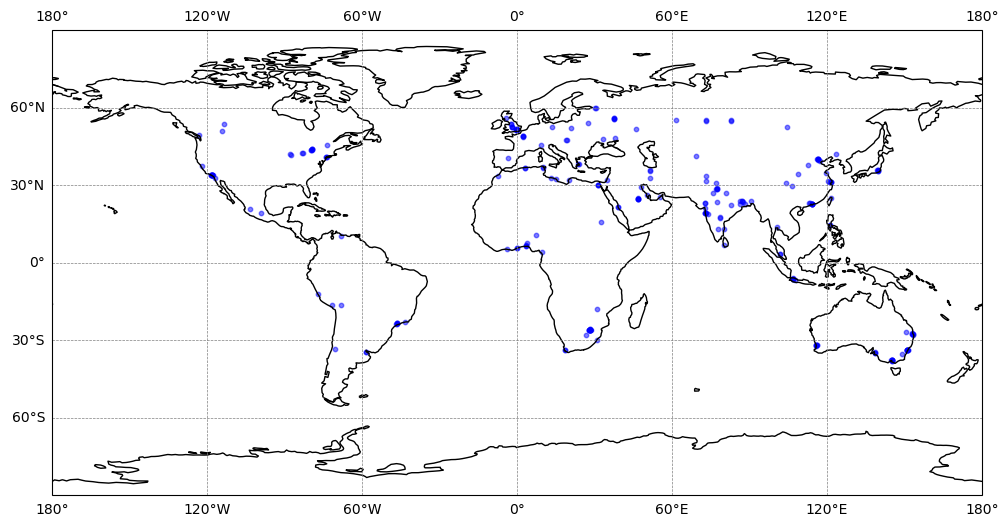

In [30]:
cx = np.degrees(np.asarray(data_WU[20]["clon"]))
cy = np.degrees(np.asarray(data_WU[20]["clat"]))

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(cx, cy, s=10, c='blue', alpha=0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl.xlabels_top = gl.ylabels_right = False

In [1]:
x=20

cx = np.degrees(np.asarray(night_cells_WU[x]["clon"]))
cy = np.degrees(np.asarray(night_cells_WU[x]["clat"]))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(cx, cy, s=15, c='blue', alpha=0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

hour = time_array[x]
time = datetime.time(hour)
time = pytz.utc.localize(time)
time = time.strftime('%H:00')

ax.set_title(f'Hour: {time} UTC')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl.xlabels_top = gl.ylabels_right = False
plt.savefig(f'nights_{x}.png', dpi=100)

NameError: name 'np' is not defined

/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  

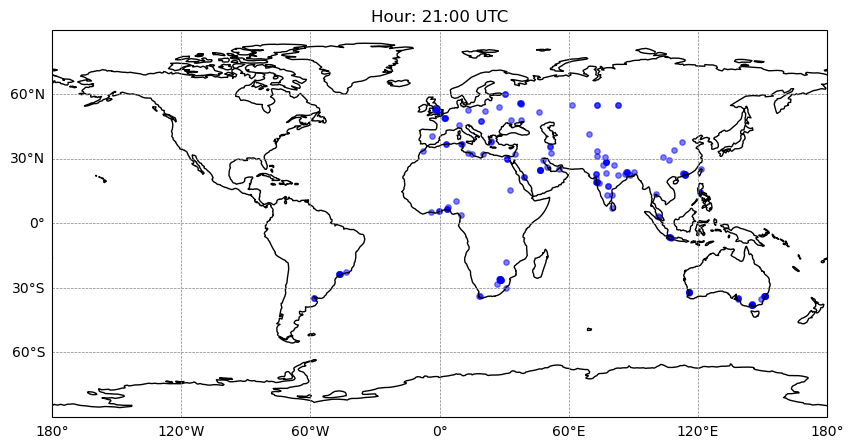

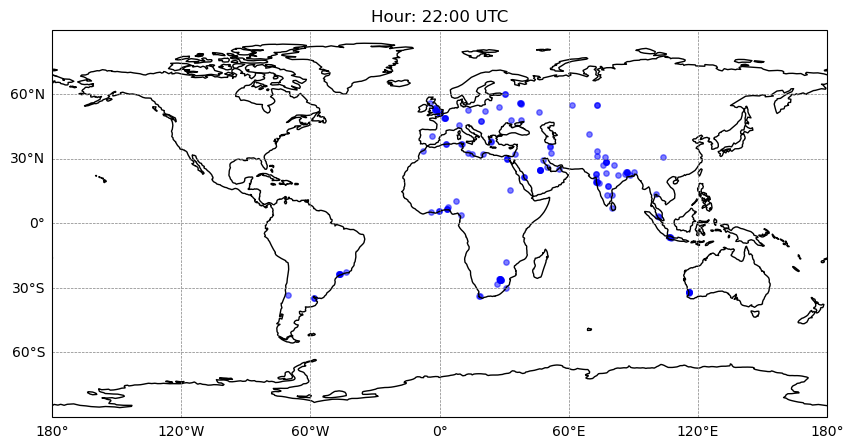

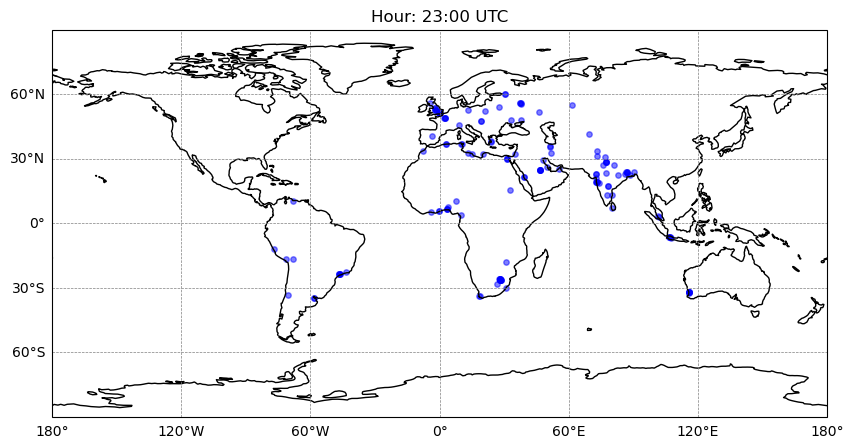

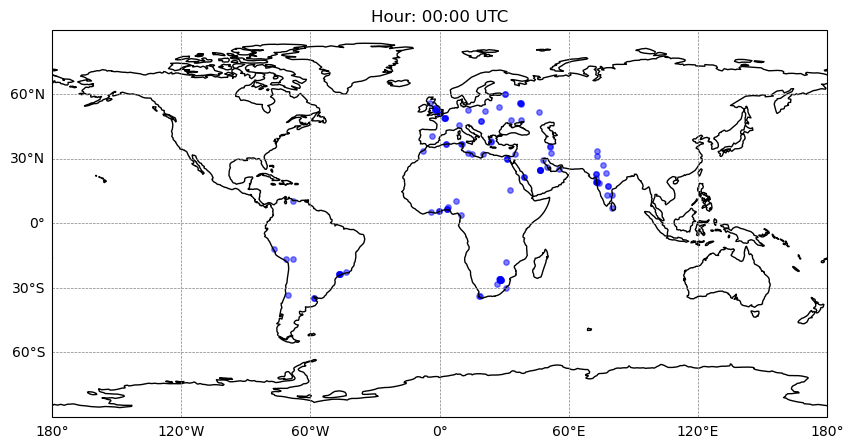

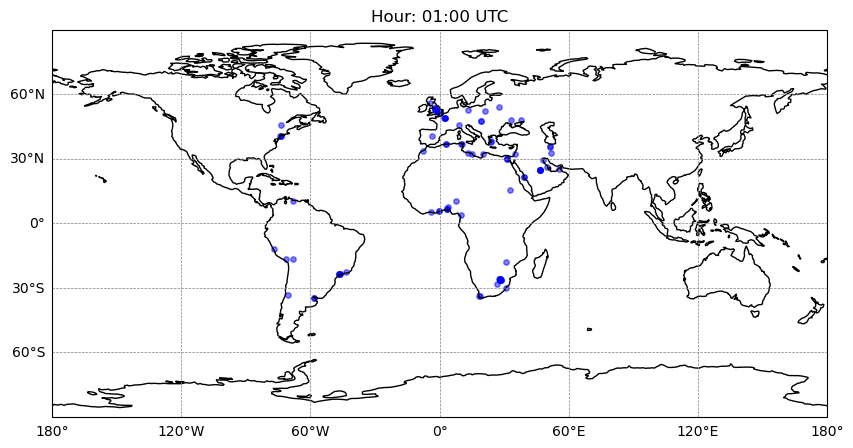

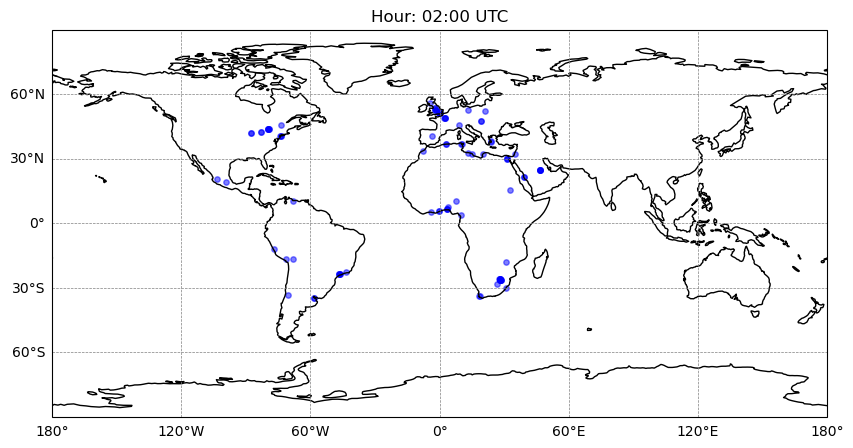

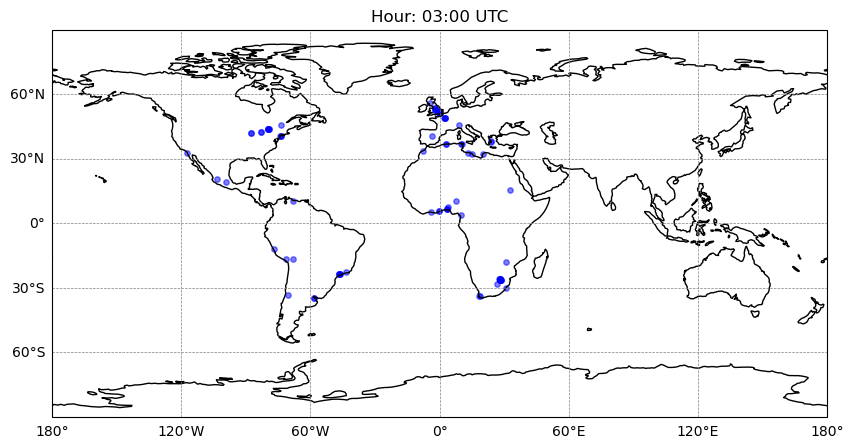

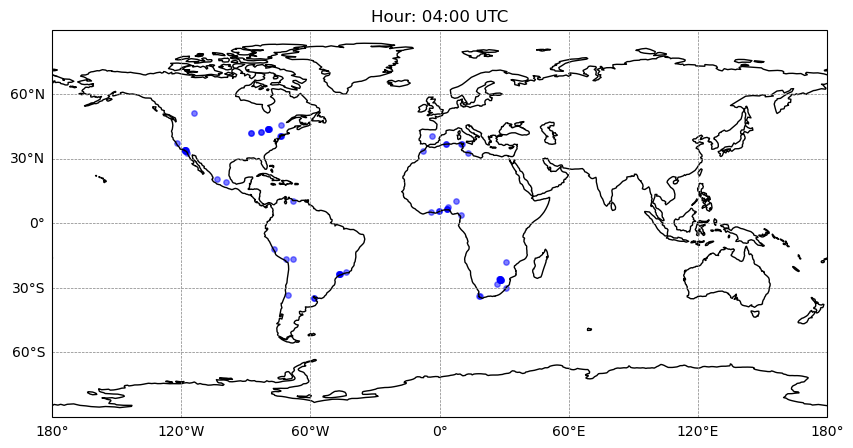

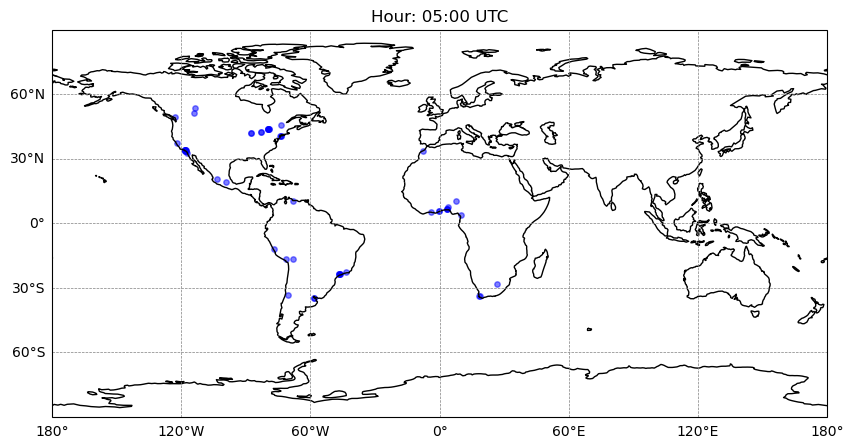

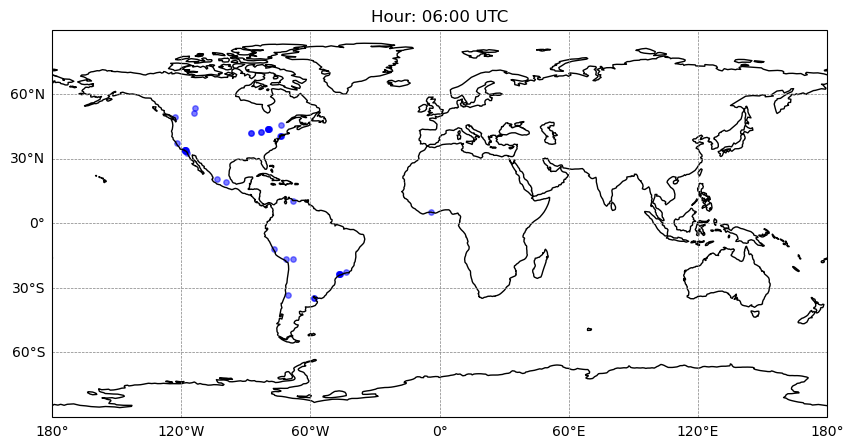

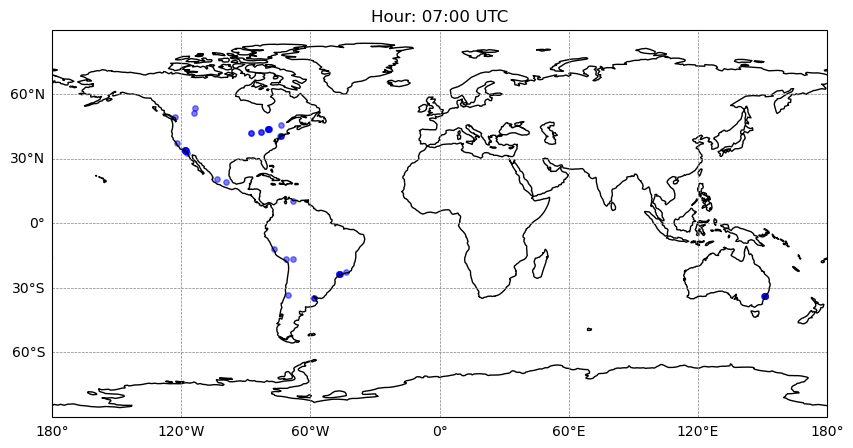

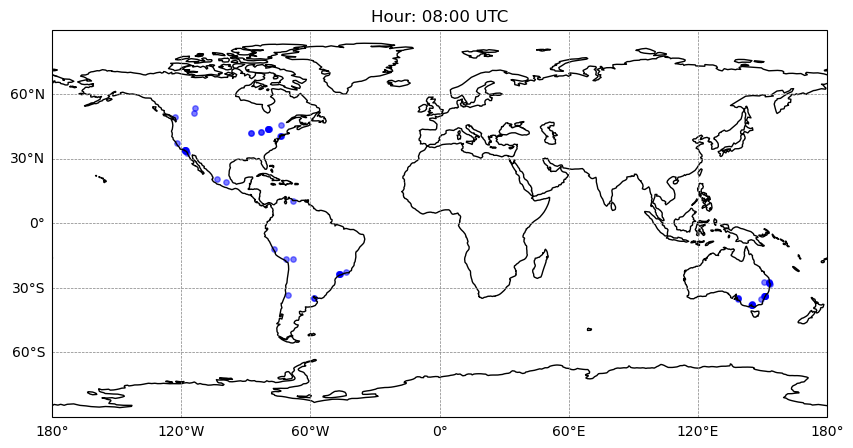

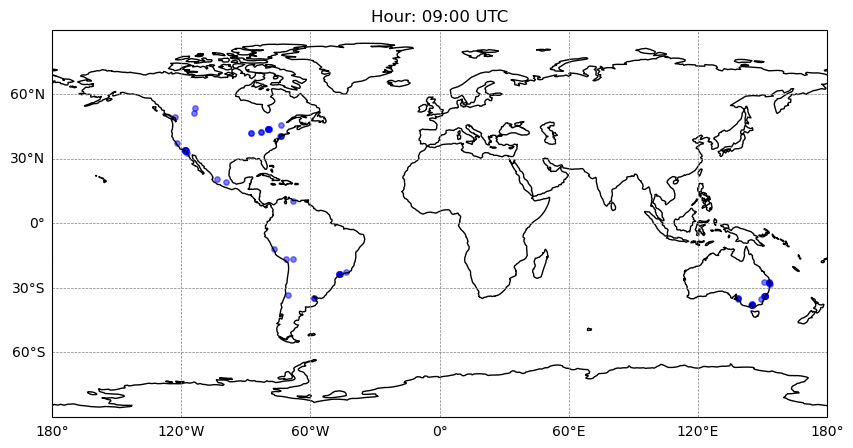

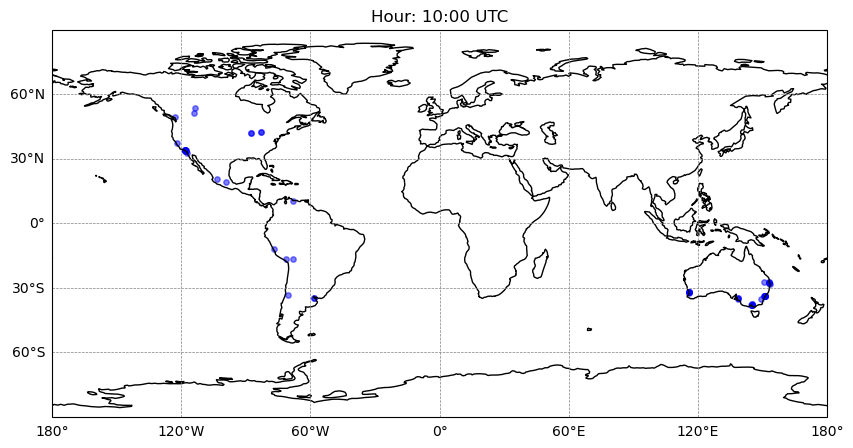

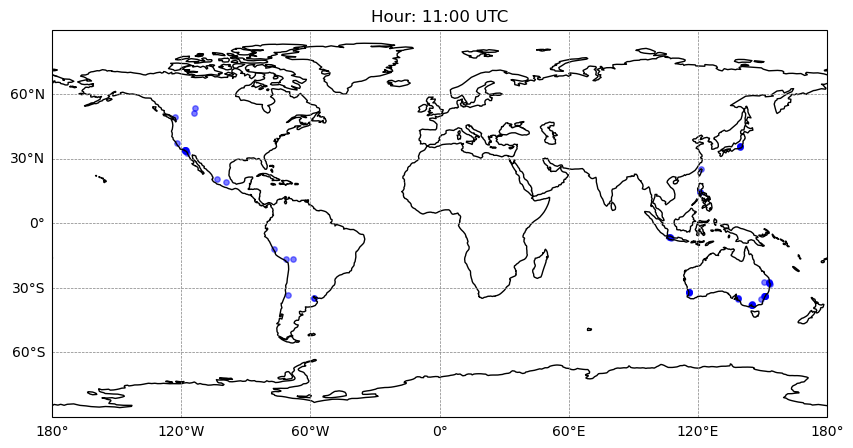

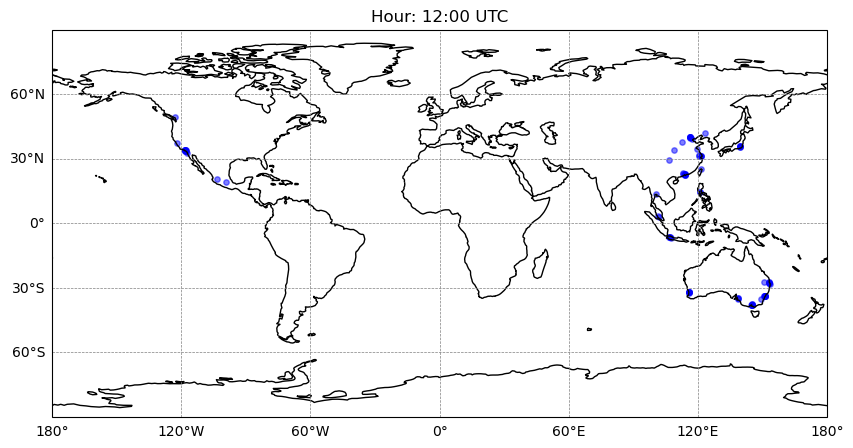

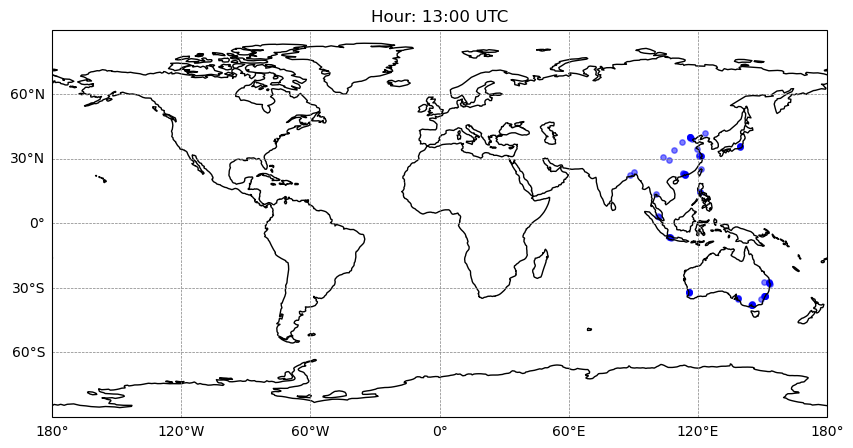

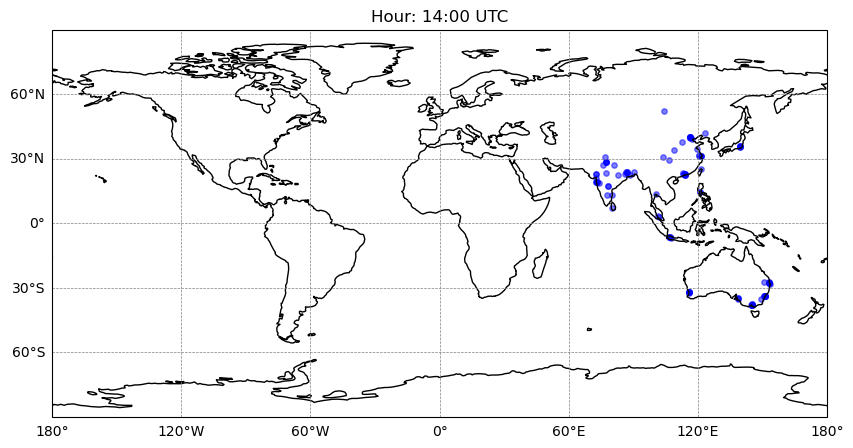

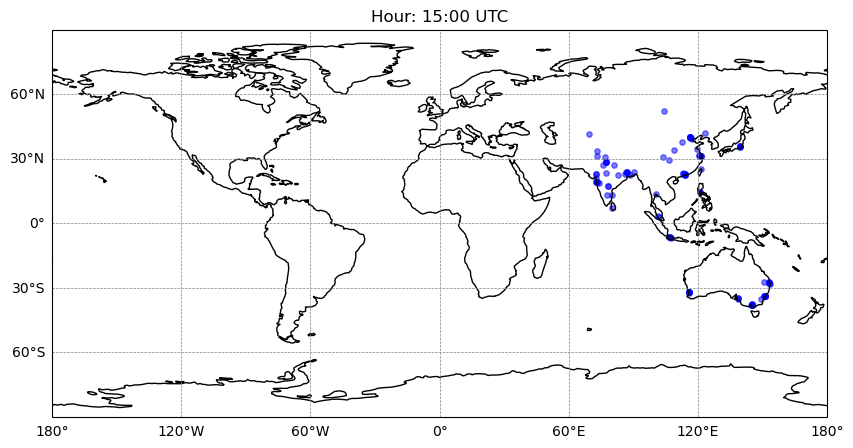

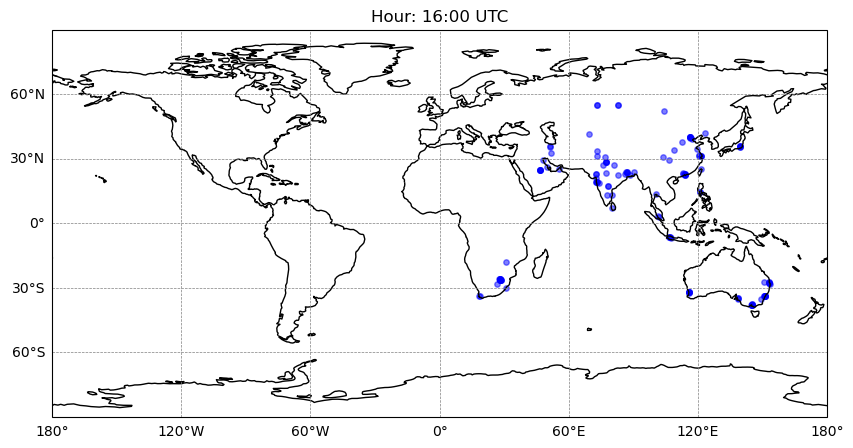

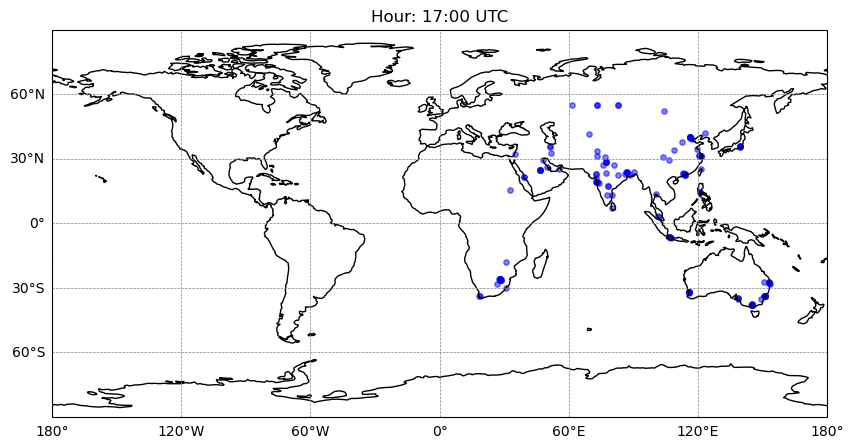

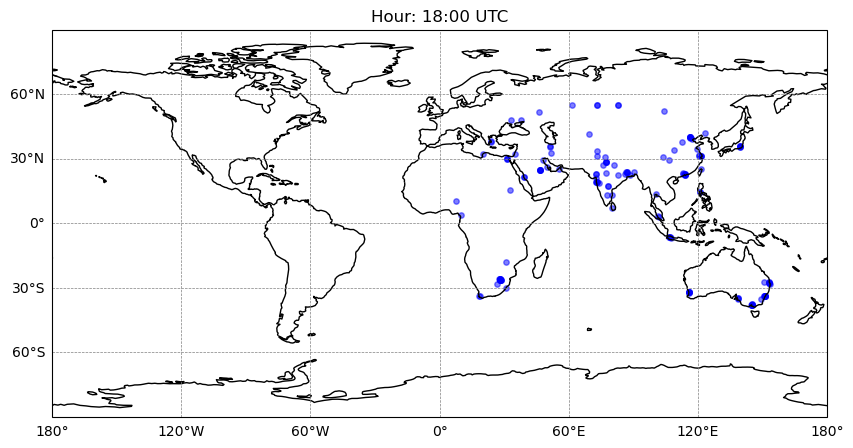

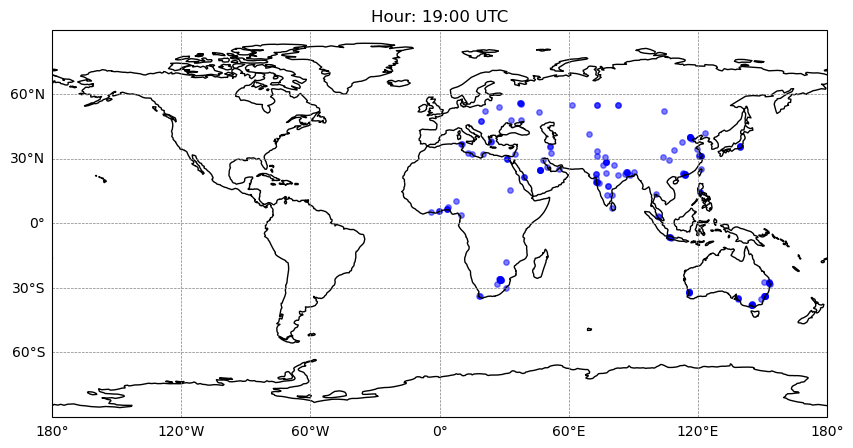

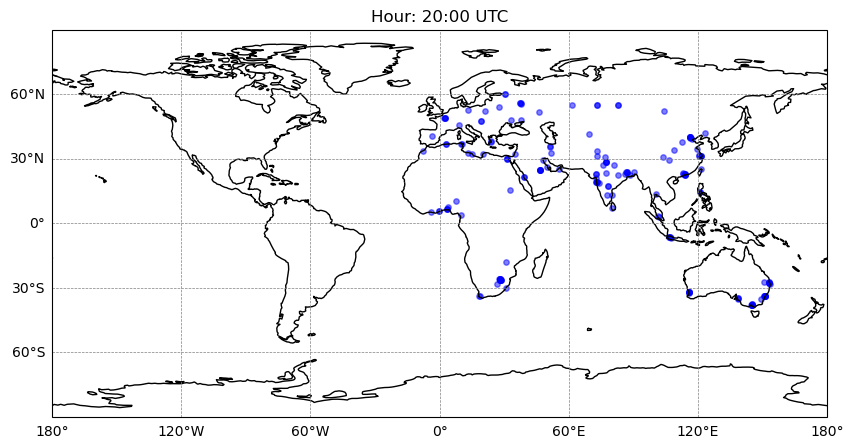

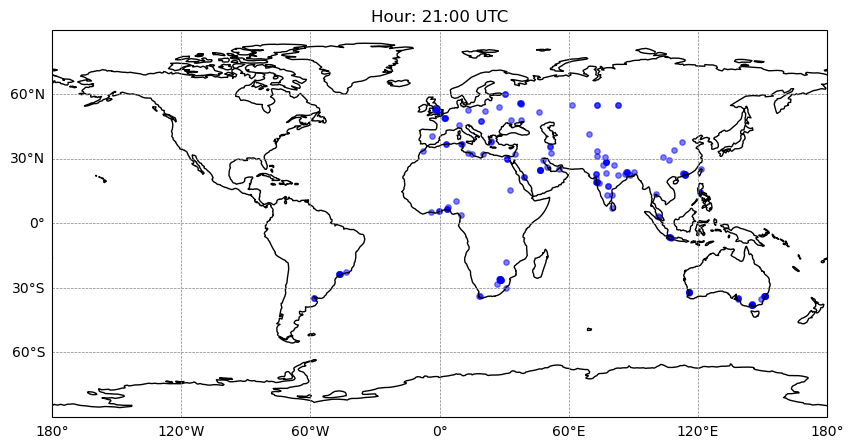

In [21]:
for x in range(1,26):
    cx = np.degrees(np.asarray(night_cells_WU[x]["clon"]))
    cy = np.degrees(np.asarray(night_cells_WU[x]["clat"]))
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.scatter(cx, cy, s=15, c='blue', alpha=0.5, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    
    hour = time_array[x]
    time = datetime.time(hour)
    time = pytz.utc.localize(time)
    time = time.strftime('%H:00')
    ax.set_title(f'Hour: {time} UTC')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
    gl.xlabels_top = gl.ylabels_right = False
    plt.savefig(f'nights_points_plotted/nights_{x}.png', dpi=100)
    plt.close

In [22]:
filenames = []  

for i in range(1, 26):
    filenames.append(f'./nights_points_plotted/nights_{i}.png')

In [23]:
images = []

In [24]:
for filename in filenames:
  images.append(imageio.v2.imread(filename))

In [25]:
imageio.mimsave('./nights_points_plotted/nights.gif', images, duration = 800)

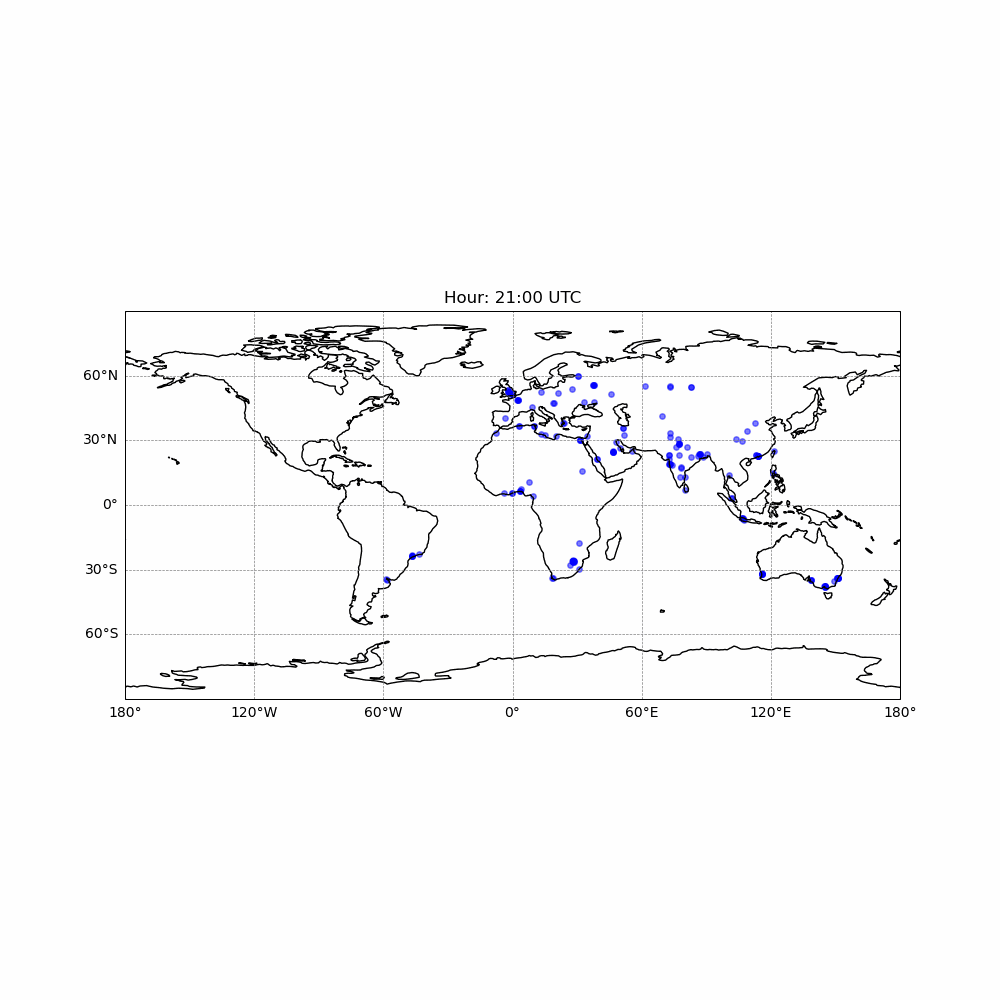

In [28]:
Image(filename='./nights_points_plotted/nights.gif')

#### Some basic statistics, doesn't really say much --> go further probably in a sepretated script

In [27]:
mean_night = {}

mean_night[1] = np.mean(T_2M_WU_nights[1])-np.mean(T_2M_NU_nights[1])
mean_night[2] = np.mean(T_2M_WU_nights[2])-np.mean(T_2M_NU_nights[2])
mean_night[3] = np.mean(T_2M_WU_nights[3])-np.mean(T_2M_NU_nights[3])


NameError: name 'T_2M_WU_nights' is not defined

In [ ]:
mean = {}

mean[1] = np.mean(T_2M_WU[1])-np.mean(T_2M_NU[1])
mean[2] = np.mean(T_2M_WU[2])-np.mean(T_2M_NU[2])
mean[3] = np.mean(T_2M_WU[3])-np.mean(T_2M_NU[3])

In [ ]:
mean_nights = (mean_night[1]+mean_night[2]+mean_night[3])/3
mean_nights

In [ ]:
mean = (mean[1]+mean[2]+mean[3])/3
mean